In [ ]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib as mpl

from sync import config
from tools.stats_perform_data import StatsPerformData, find_spadl_event_types
from sync.elastic import ELASTIC

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)

%matplotlib inline
mpl.rcParams['animation.embed_limit'] = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Preparation

Our code requires tracking data in the [kloppy](https://kloppy.pysport.org) format and event data in the [SPADL](https://socceraction.readthedocs.io/en/latest/documentation/spadl/spadl.html) format. If you have data with other formats, you should replace this with code that aligns with your own data format.

We will soon upload the tutorial code using [Sportec Open DFL Dataset (Bassek et al., 2025)](https://www.nature.com/articles/s41597-025-04505-y). Before that, please check `sync/schema.py` to figure out the valid input format for ELASTIC.

In [17]:
file_idx = 304

events = pd.read_parquet(config.EVENT_PATH)
events["utc_timestamp"] = pd.to_datetime(events["utc_timestamp"])
events = find_spadl_event_types(events)
events[events["spadl_type"].isna()]["action_type"].value_counts()

trace_files = np.sort([f for f in os.listdir(config.TRACKING_DIR) if f.endswith(".parquet")])
match_id = trace_files[file_idx].split(".")[0]

lineups = pd.read_parquet(config.LINEUP_PATH)
match_lineup = lineups.loc[lineups["stats_perform_match_id"] == match_id].set_index("player_id")
match_events = events[
    (events["stats_perform_match_id"] == match_id)
    & (events["spadl_type"].notna())
    & (events["player_id"].notna())
].copy()
match_tracking = pd.read_parquet(f"{config.TRACKING_DIR}/{match_id}.parquet")

match = StatsPerformData(match_lineup, match_events, match_tracking)
input_events = match.format_events_for_syncer()
input_tracking = match.format_tracking_for_syncer()

### Data Sychronization

In [18]:
syncer = ELASTIC(input_events, input_tracking)
syncer.run()

Post-syncing minor events: 100%|██████████| 166/166 [00:04<00:00, 34.50it/s]


### Visualizing Individual Windows for Validation

Event 57: pass by home_15
Matched frame: 5667
Matched time: P1-03:46.68


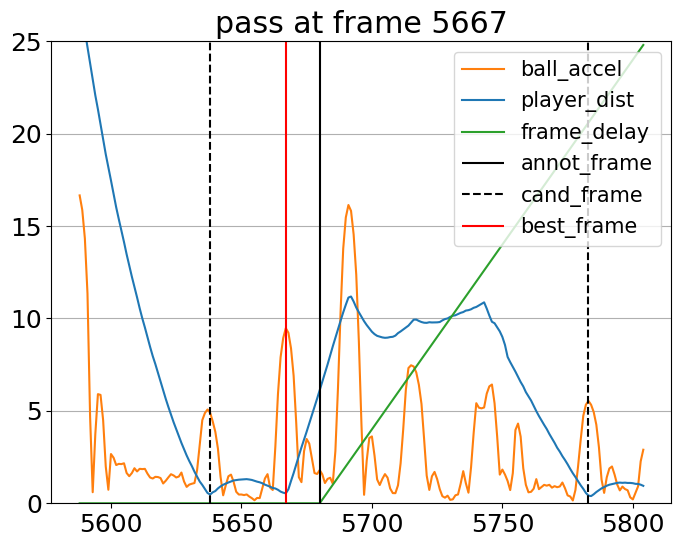

,frame_delay,player_speed,player_accel,ball_accel,ball_height,player_dist,kick_dist,score
frame,,,,,,,,
5638,0,2.007957,3.905000,25.377590,0.09,0.473814,1.306025,82.065336
5667,0,4.398070,4.021870,47.393076,0.10,0.536656,11.188052,96.422291
5783,103,1.525979,1.402477,27.684770,0.11,0.389487,1.118302,48.916630


In [20]:
# pass-like event
syncer.plot_window_features(57)

Event 80: ball_recovery by away_1
Matched frame: 7336
Matched time: P1-04:53.44


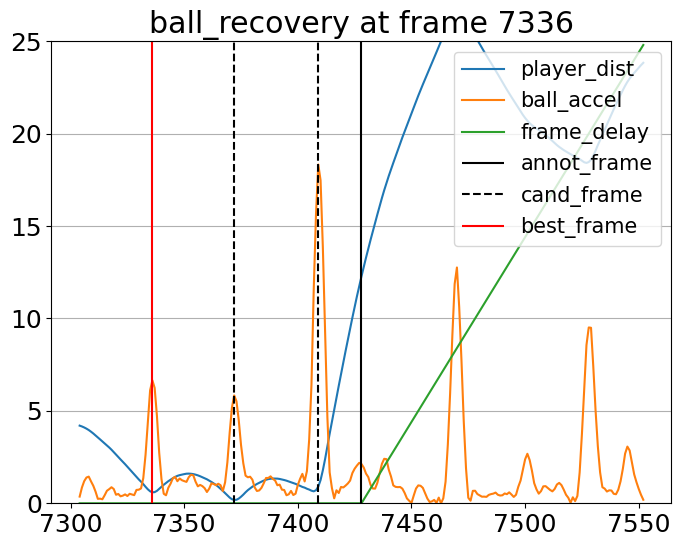

,frame_delay,ball_accel,ball_height,player_dist,rel_speed,rel_accel,kick_dist,score
frame,,,,,,,,
7336,0,33.260144,0.10,0.592340,2.840516,33.260144,4.201288,92.856219
7372,0,29.183914,0.11,0.181734,2.850577,29.183914,1.605486,85.210383
7409,0,91.660099,0.08,0.646724,17.274212,91.660099,1.339977,81.048412


In [14]:
# incoming event
syncer.plot_window_features(80)

Current event: pass by away_2
Next event: pass by away_1

Detected receiver: away_1
Receiving frame: 162.0
Receiving time: P1-6.48


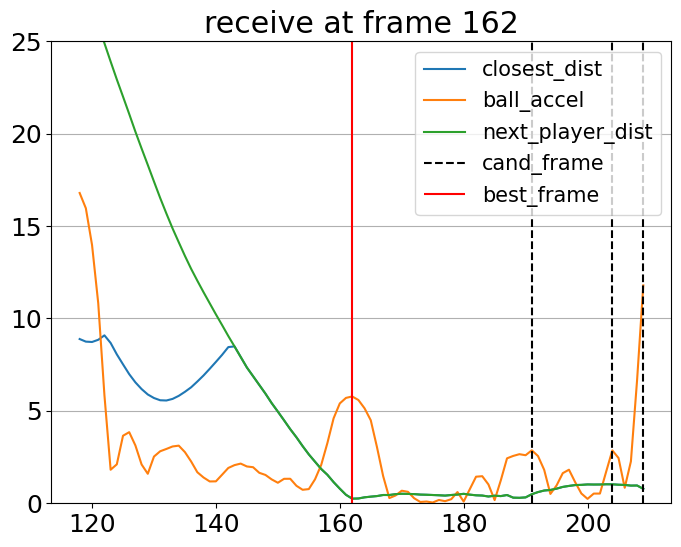

,ball_height,ball_accel,next_player_dist,closest_dist,closest_player,kick_dist,score
frame,,,,,,,
162,0.14,28.903255,0.250200,0.250200,0,28.673458,95.830001
191,0.12,14.338035,0.295296,0.295296,0,0.023888,63.120374
204,0.12,14.308607,0.957079,0.957079,0,0.002288,51.945883
209,0.06,58.954823,0.780577,0.780577,0,0.245532,63.218050


In [18]:
# receive
syncer.receive_det.plot_window_features(3)

Event 79: tackle by away_12
Matched frame: 7266
Matched time: P1-04:50.64


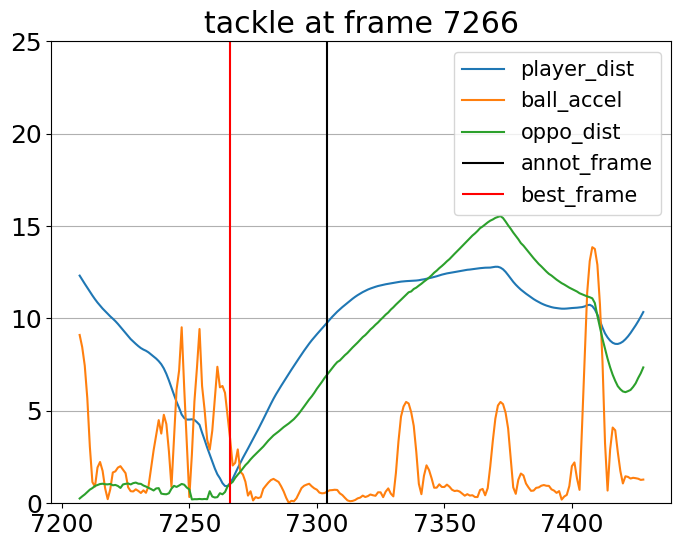

In [16]:
# minor event
syncer.plot_window_features(79)